In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import statsmodels.formula.api as smfa
from statsmodels.stats.anova import anova_lm

In [3]:
cats_df = pd.read_csv('data/cats.csv')
cats_df.head()

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3


In [7]:
mu = 2.6
ss.shapiro(cats_df['Bwt']), ss.shapiro(cats_df['Hwt'])

(ShapiroResult(statistic=0.9518786668777466, pvalue=6.730248423991725e-05),
 ShapiroResult(statistic=0.9603861570358276, pvalue=0.0003653781022876501))

In [10]:
ss.wilcoxon(cats_df['Bwt'] - mu, alternative='two-sided')

WilcoxonResult(statistic=3573.0, pvalue=0.02524520294814093)

In [11]:
ss.ttest_1samp(cats_df['Bwt'], popmean=mu)

Ttest_1sampResult(statistic=3.0564867998078107, pvalue=0.0026730362561723613)

In [12]:
data = {'before':[7,3,4,5,2,1,6,6,5,4],
       'after':[8,4,5,6,2,3,6,8,6,5]}
data_df = pd.DataFrame(data)
data_df.head()

,before,after
0,7,8
1,3,4
2,4,5
3,5,6
4,2,2


In [14]:
ss.shapiro(data_df['after'] - data_df['before'])

ShapiroResult(statistic=0.8148398399353027, pvalue=0.021947871893644333)

In [16]:
ss.ttest_rel(data_df['after'], data_df['before'], alternative='greater')

Ttest_relResult(statistic=4.743416490252569, pvalue=0.0005269356285082764)

In [17]:
female = cats_df.loc[cats_df['Sex'] == 'F', 'Bwt']
male = cats_df.loc[cats_df['Sex'] == 'M', 'Bwt']

In [19]:
ss.levene(female, male)

LeveneResult(statistic=19.43101190877999, pvalue=2.0435285255189404e-05)

In [20]:
ss.ttest_ind(female, male, equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=-8.70948849909559, pvalue=8.831034455859356e-15)

<AxesSubplot:>

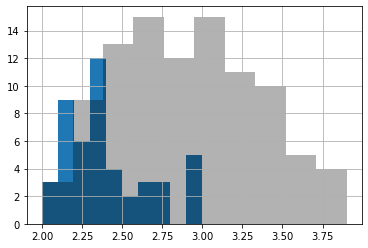

In [23]:
female.hist()
male.hist(color='black', alpha=0.3)

In [25]:
iris_df = pd.read_csv('data/iris.csv')
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [26]:
target_list = iris_df['target'].unique()
setosa = iris_df.loc[iris_df['target'] == 'Iris-setosa', 'sepal width']
versicolor = iris_df.loc[iris_df['target'] == 'Iris-versicolor', 'sepal width']
virginica = iris_df.loc[iris_df['target'] == 'Iris-virginica', 'sepal width']

In [27]:
ss.shapiro(setosa), ss.shapiro(versicolor), ss.shapiro(virginica)

(ShapiroResult(statistic=0.968691885471344, pvalue=0.20465604960918427),
 ShapiroResult(statistic=0.9741330742835999, pvalue=0.33798879384994507),
 ShapiroResult(statistic=0.9673910140991211, pvalue=0.1809043288230896))

In [28]:
ss.levene(setosa, versicolor, virginica)

LeveneResult(statistic=0.6475222363405327, pvalue=0.5248269975064537)

In [29]:
ss.f_oneway(setosa, versicolor, virginica)

F_onewayResult(statistic=47.36446140299382, pvalue=1.3279165184572242e-16)

In [31]:
mc = MultiComparison(data=iris_df['sepal width'], groups=iris_df['target'])
tukey = mc.tukeyhsd(alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Iris-setosa,Iris-versicolor,-0.648,0.0,-0.8092,-0.4868,True
Iris-setosa,Iris-virginica,-0.444,0.0,-0.6052,-0.2828,True
Iris-versicolor,Iris-virginica,0.204,0.009,0.0428,0.3652,True


In [32]:
ss.kruskal(setosa, versicolor, virginica)

KruskalResult(statistic=62.49463010053111, pvalue=2.6882119006774528e-14)

In [33]:
pg.welch_anova(data=iris_df, dv='sepal width', between='target')

,Source,ddof1,ddof2,F,p-unc,np2
0,target,2,97.369597,43.303381,3.519723e-14,0.391881


In [34]:
mt_df = pd.read_csv('data/mtcars.csv')
mt_df.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [40]:
formula = 'mpg ~ C(am) + C(cyl) + C(am):C(cyl)'
model = smfa.ols(formula, mt_df).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(3)

,sum_sq,df,F,PR(>F)
C(am),36.767,1.0,3.999,0.056
C(cyl),456.401,2.0,24.819,0.000
C(am):C(cyl),25.437,2.0,1.383,0.269
Residual,239.059,26.0,NaN,NaN


In [45]:
mc = MultiComparison(data=mt_df['mpg'], groups=mt_df['cyl'])
tukey = mc.tukeyhsd(alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
4,6,-6.9208,0.0003,-10.7693,-3.0722,True
4,8,-11.5636,0.0,-14.7708,-8.3565,True
6,8,-4.6429,0.0112,-8.3276,-0.9581,True


In [46]:
tit_df = pd.read_csv('data/titanic.csv')
obs = tit_df[tit_df['survived'] == 1]['sex'].value_counts().reindex(['female', 'male'])
exp = tit_df['sex'].value_counts(normalize=True).reindex(['female', 'male']).mul(obs.sum())
obs, exp

(female    233
 male      109
 Name: sex, dtype: int64,
 female    120.525253
 male      221.474747
 Name: sex, dtype: float64)

In [51]:
ss.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=162.08166685161612, pvalue=3.970516389658729e-37)

In [52]:
table = pd.crosstab(tit_df['class'], tit_df['survived'])
table

survived,0,1
class,,
First,80,136
Second,97,87
Third,372,119


In [56]:
chi, p, ddof, f_exp = ss.chi2_contingency(observed=table)
chi, p, ddof, f_exp

(102.88898875696056,
 4.549251711298793e-23,
 2,
 array([[133.09090909,  82.90909091],
        [113.37373737,  70.62626263],
        [302.53535354, 188.46464646]]))